This notebook contains the experiments for the case where model have access to initial web context. Here we try to have the models come up with novel search queries during the debate

In [1]:
import sys
sys.path.append('..')

import argparse
import torch

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import process_images, tokenizer_image_token, get_model_name_from_path

import requests
from PIL import Image
import json
from transformers import TextStreamer

from utils.data import get_data, show_data
from utils.prompts import initial_prompt_with_context, round1_prompt, debate_prompt

In [2]:
MODEL_NAME = "liuhaotian/llava-v1.6-34b"
temperature = 0.2
max_new_tokens = 512
num_models = 2
models = []

disable_torch_init()

model_name = get_model_name_from_path(MODEL_NAME)
for i in range(num_models):
    tokenizer, model, image_processor, context_len = load_pretrained_model(MODEL_NAME, model_base=None, model_name=model_name, load_8bit=False, load_4bit=False, device_map="auto")
    models.append({"tokenizer":tokenizer, "model":model, "image_processor":image_processor, "context_len":context_len})

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/55/kumud/anaconda/envs/experiments/lib/python3.12/site-packages/torch/nn/modules/module.py:2047: UserWarning: for vision_model.embeddings.patch_embedding.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assi

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

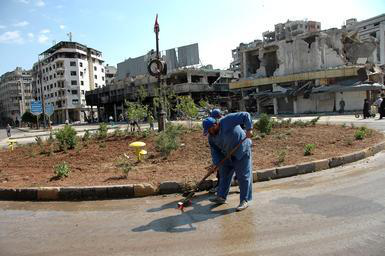

Caption:  Flashmob protest at Crossrail site in Central London by Unite union members in protest against blacklisting and sackings of union officials and members
Misinformation (Ground Truth): False


In [3]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"

conv = []
roles = []

for i in range(num_models):
    conv.append(conv_templates[conv_mode].copy())
    if "mpt" in model_name.lower():
        roles.append(('user', 'assistant'))
    else:
        roles.append(conv[i].roles)

image, caption, img_path, annotation = get_data(7)
display(image)
show_data(0)
image_size = image.size

# Similar operation in model_worker.py
image_tensor = process_images([image], models[0]['image_processor'], models[0]['model'].config)
if type(image_tensor) is list:
    image_tensor = [image.to(models[0]['model'].device, dtype=torch.float16) for image in image_tensor]
else:
    image_tensor = image_tensor.to(models[0]['model'].device, dtype=torch.float16)


In [4]:
def generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens):
    print("AGENT - {}: ".format(i+1))
    prompt = conv[i].get_prompt()

    input_ids = tokenizer_image_token(prompt, models[i]['tokenizer'], IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(models[i]['model'].device)
    stop_str = conv[i].sep if conv[i].sep_style != SeparatorStyle.TWO else conv[i].sep2
    keywords = [stop_str]
    streamer = TextStreamer(models[i]['tokenizer'], skip_prompt=True, skip_special_tokens=True)

    with torch.inference_mode():
        output_ids = models[i]['model'].generate(
            input_ids,
            images=image_tensor,
            image_sizes=[image_size],
            do_sample=True if temperature > 0 else False,
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            streamer=streamer,
            use_cache=True)

    outputs = models[i]['tokenizer'].decode(output_ids[0]).strip()
    return outputs

def retrieve_summary(key):
    with open("../scripts/final_summaries.json", "r") as f:
        data = json.load(f)
    return data[key]

In [5]:
def disambiguation_prompt(role, text):
    prompt = """ {}: I see what you mean and this is what I think: {}.
                I want you to find loopholes in my explanation. 
                Generate 3 disambiguation queries that I can answer to either correct my wrong argument or strengthen my exisiting argument. 
            """.format(role, text)
    return prompt

In [6]:
temperature = 0.2
max_new_tokens = 512
num_models = 2
num_rounds = 3

In [7]:
search_result = ""
search_done = False
summary_key = str(annotation['id'])+"_"+str(annotation["image_id"])
context = retrieve_summary(summary_key)
print("CONTEXT: \n\n", context)
image_size = image.size

temp = ""
model_responses = {}
for i in range(num_models):
    model_responses[i] = {"falsified":"", "output":""}
for round in range(num_rounds+1):
    for i in range(num_models):
        if round == 0:
            inp = initial_prompt_with_context(roles[i][0], caption, context)
        elif round == 1:
            if i == 1:
                inp = round1_prompt(roles[i][0], temp)
            else:
                inp = round1_prompt(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        else:
            inp = debate_prompt(roles[i][0], conv[(i+1)%num_models].messages[-1][-1])
        if image is not None:
            # first message
            if models[i]['model'].config.mm_use_im_start_end:
                inp = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + inp
            else:
                inp = DEFAULT_IMAGE_TOKEN + '\n' + inp
            if round == 0 and i == 1:
                image = None

        conv[i].append_message(conv[i].roles[0], inp)
        conv[i].append_message(conv[i].roles[1], None)
        outputs = generate_output(i, conv, models, image_tensor, temperature, image_size, max_new_tokens)
        conv[i].messages[-1][-1] = outputs
        if i == 0 and round == 0:
            temp = outputs
        if round == num_rounds-1:
            #final answer from the model
            if "YES" in outputs:
                model_responses[i]["falsified"] = True
                model_responses[i]["output"] = outputs
            elif "NO" in outputs:
                model_responses[i]["falsified"] = False
                model_responses[i]["output"] = outputs
            elif "UNSURE" in outputs:
                model_responses[i]["falsified"] = "Unsure"
                model_responses[i]["output"] = outputs

CONTEXT: 

 SUMMARY:
            
            The text describes the current situation in the Middle East, specifically in Israel and Palestine. The Israeli military has launched airstrikes on Gaza, killing over 200 militants and destroying homes and infrastructure. Palestinian militants have fired rockets into Israel, killing 12 people, including a 5-year-old boy and a 16-year-old girl. A cease-fire has been brokered by Egypt, but it is fragile and there have been scattered clashes at the Al-Aqsa Mosque. The text also mentions that the conflict has been fueled by Israel's occupation of Palestinian lands and Hamas' refusal to recognize Israel's right to exist. Additionally, the text notes that another US intervention is possible, as the Biden administration has been dragged back into the conflict. Finally, the text mentions that a swarm of locusts has descended on Egypt, causing great damage.

Please let me know if you would like me to make any changes or if you have any further questi

not depict the conflict between Israel and Palestine, nor does it show the aftermath of airstrikes or rocket attacks.

The image does not contain any watermarks, text, or other details that would indicate the location, time, or other important information. The man in the image is wearing a blue uniform, which could suggest he is a city worker or a member of a cleaning crew, but this does not provide any specific information about the location or the circumstances of the photo.

Given the lack of context and the mismatch between the image and the text provided, it is reasonable to conclude that the image is being used out of context to spread misinformation. Therefore, the answer to the question is:

UNSURE
AGENT - 2: 
Based on the image provided and the context given, it appears that the image is being used out of context to spread misinformation. The image shows a person working on a road or sidewalk, which does not match the description of the bomb-damaged headquarters in Aleppo. The